In [15]:
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('data/Roads_InfoAboutEachLRP.xlsx')
df.head()

,road,chainage,lrp,lat,lon,type,name
0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing


### First round cleaning: start with biggest outliers:

One degree = 111.1km (lat/lon)

In [6]:
N1 = df.loc[df.road=='N1']
N1.shape

(1348, 7)

/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='lon', ylabel='lat'>

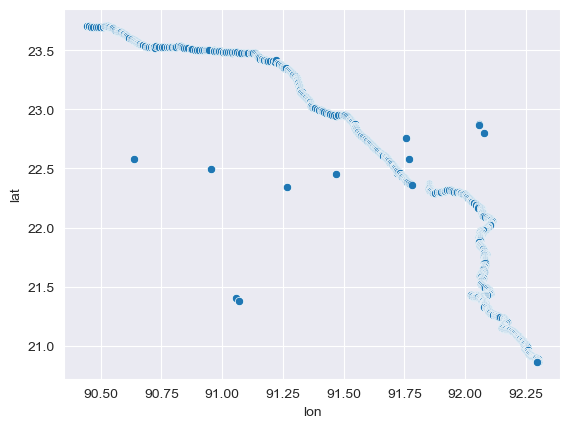

In [7]:
sns.set_style('darkgrid')
sns.scatterplot(x='lon',y='lat',data=N1)

In [8]:
av_x, av_y = N1.lon.median() , N1.lat.median() # use kde here? # use percentiles here?

min_x, max_x = av_x - .1, av_x + .1
min_y, max_y = av_y - .1, av_y + .1

for i in range(1,len(N1.index)): # ignore first and last data point 
    # if value is outside interval, we consider it an outlier 
    if min_x < N1.loc[i,'lon'] < max_x:
        N1.loc[i,'lon'] = (N1.loc[i-1,'lon'] + N1.loc[i+1,'lon']) / 2
        av_x # replace with average between first and last point 
    if min_y < N1.loc[i,'lat'] < max_y: 
        N1.loc[i,'lat'] = (N1.loc[i-1,'lat'] + N1.loc[i+1,'lat']) / 2 

/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='lon', ylabel='lat'>

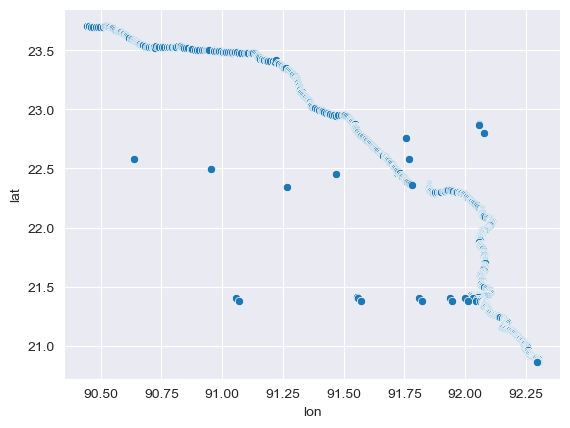

In [9]:
sns.scatterplot(x='lon',y='lat',data=N1)


Code fails to capture outliers. Let's clean road by road instead

In [11]:
N1 = df.loc[df.road=='N1']
N1.shape

(1348, 7)

In [12]:
for i in N1.index:
    while i in range(5, len(N1)-5):
        x_min, x_max = N1.loc[i-5:i+5,'lon'].median() * .999 , N1.loc[i-5:i+5,'lon'].median() * 1.001 # how big do we want to make search depth?
        y_min, y_max = N1.loc[i-5:i+5,'lat'].median() * .999,  N1.loc[i-5:i+5,'lat'].median() * 1.001 
        
        if not x_min <  N1.loc[i,'lon'] < x_max: # check for outliers and overwrite 
            N1.loc[i,'lon'] = (N1.loc[i-1,'lon'] + N1.loc[i+1,'lon']) / 2 # position point right in between last and next point 

        if not y_min < N1.loc[i,'lat'] < y_max:
            N1.loc[i,'lat'] = (N1.loc[i-1,'lat'] + N1.loc[i+1,'lat']) / 2 # position point right in between last and next point 
        i+=1
        break


/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/philip/anaconda3/envs/datascience/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='lon', ylabel='lat'>

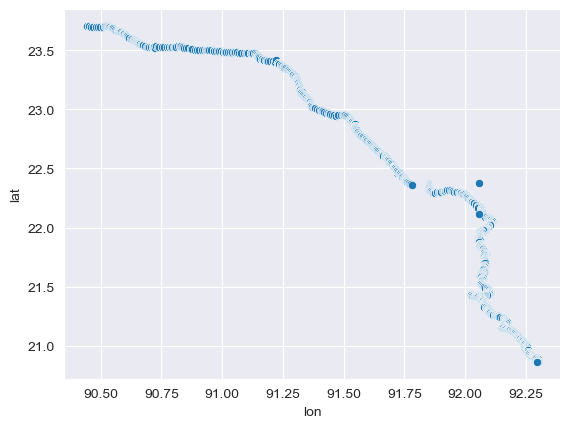

In [13]:
sns.scatterplot(x='lon',y='lat',data=N1)


In [19]:
def cleaning(data):
            
    for i in data.index:
    # check if i is inside first or last five iterations and compute moving averages acordingly 
        
         if i in range(5, len(data)-5):
            x_min, x_max = data.loc[i-5:i+5,'lon'].median() * .999 , data.loc[i-5:i+5,'lon'].median() * 1.001 # how big do we want to make search depth?
            y_min, y_max = data.loc[i-5:i+5,'lat'].median() * .999,  data.loc[i-5:i+5,'lat'].median() * 1.001 
        
            if not x_min <  data.loc[i,'lon'] < x_max: # check for outliers and overwrite 
                data.loc[i,'lon'] = (data.loc[i-1,'lon'] + data.loc[i+1,'lon']) / 2 # position point right in between last and next point 

            if not y_min < data.loc[i,'lat'] < y_max:
                data.loc[i,'lat'] = (data.loc[i-1,'lat'] + data.loc[i+1,'lat']) / 2 # position point right in between last and next point 
    return data

In [22]:
keys = df.road.unique()
final_df = pd.DataFrame()

chunks = []  # collect per-road results to avoid deprecated DataFrame.append
for key in keys:
    sub_df = cleaning(df.loc[df.road == key])
    # run twice:
    sub_df = cleaning(sub_df)
    chunks.append(sub_df)

# pandas >= 2.0: use concat instead of DataFrame.append
if chunks:
    final_df = pd.concat(chunks, ignore_index=True)
else:
    final_df = pd.DataFrame(columns=df.columns)

<Axes: xlabel='lon', ylabel='lat'>

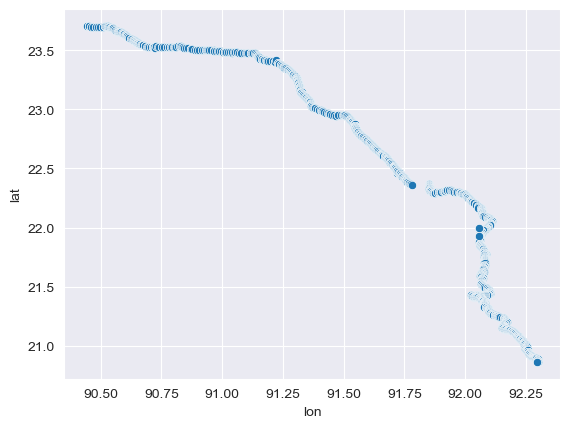

In [23]:
sns.scatterplot(x='lon',y='lat',data=final_df.loc[final_df.road=='N1'])
